# Machine learning - Food

Agarro 6 platos comibinados y busco como se parecen.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist

import json
import urllib.request
import itertools

from sklearn.cluster import KMeans

## 1. Obtener datos

Lo dicho. Hacemos la llamada y esperamos la respuesta tipo JSON con nombres, ingredientes y metodos de cocinar

``` 
HTTP GET http://donde.sea:9030/dishes/all 

HTTP RESPONSE: JSON 
[{"name":"plato combinado 1", "ingredientes": ["pollo", "patata", "pimiento"], "method": "fried"]}, {...}]

```

Yo hago un fake de esto ya que no tiene ninguna ciencia.

In [2]:
url = 'https://raw.githubusercontent.com/rafalszota/Food/master/data.json.txt'

with urllib.request.urlopen(url) as url:
    dishes = json.loads(url.read().decode())


La repuesta me da en ```dishesh``` un array de JSON como estos ejemplos:

In [3]:
dishes[0], dishes[1] 

({'cooking': ['frito'],
  'ingredients': ['pollo', 'patata', 'pimiento'],
  'name': 'plato combinado 1'},
 {'cooking': ['frito'],
  'ingredients': ['lomo', 'huevo', 'patata', 'pimiento'],
  'name': 'plato combinado 2'})

## 2. Transformar datos

Esto lo he simplificado mucho usando pandas. La idea es lo que en estadistica se llama dummy variables. En definitiva, lo dicho antes: mis criterios para ver que platos se parecen son:

1. Tienen el mismo nombre 
2. Tienen ingredientes similares
3. El metodo de coccion es el mismo (hervido, frito, al horno, etc.)

Por ahora paso de utilizar el metodo de coccion, pero la idea es la misma que los ingredientes. Por eso, aqui trabajo solo el punto 2. 

Ya lo ves, se hace bastante sencillo ya que con 3 lineas de codigo tenemos una matriz que vamos a usar para todo el concepto. 


In [4]:
names, ingredients = zip(*[(dish['name'], dish['ingredients']) for dish in dishes])
names, ingredients = pd.Series(names), pd.Series(ingredients)

df = pd.get_dummies(ingredients.apply(pd.Series).stack()).sum(level=0).set_index(names)

La matriz quedaria algo asi:

In [5]:
df

,asado completo,asado variado,huevo,lomo,morcilla,patata,pechuga pollo,pechugas,pimiento,pimiento rojo,pimiento verde,pollo,ternera,txistorra
plato combinado 1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
plato combinado 2,0,0,1,1,0,1,0,0,1,0,0,0,0,0
plato combinado 3,0,0,1,0,0,1,0,1,1,0,0,0,0,0
plato combinado 4,0,0,1,0,0,1,0,0,1,0,0,0,1,0
plato combinado 5,0,1,0,1,0,1,1,0,0,1,1,0,1,0
plato combinado 6,1,0,0,1,1,1,1,0,0,1,1,0,1,1


## 3. Ingredientes comues

En cuanto mas pienso, mas veo que por aqui tenia que haber empezado desde el primer momento. Junto las ideas de antes y determino ingredientes comunes.


Hay que fitrar fuera los ingredientes mas comunes. Ejemplo: todos los platos llevan sal. Pues el hecho de llevar sal no me aporta informacion addicional asi que lo puedo quitar de mi matriz de ingredientes (al menos a efectos de pareciencia).

Como de habitual son varios ingredientes? Mutiplicamos la matriz de platos e ingredientes $M$ por si misma 
y normalizamos por numero maximo de platos que tenemos. Sale algo asi:
    
$$ X = \frac{M^TM}{n} $$

donde $n$ es el numero de los rows (platos en la matriz). Esto nos da una norma para los ingredientes que aparecen juntos de manera comun. Por otro lado en la diagonal tenemos el peso de cada ingrediente respecto un total de los ingredientes.

In [6]:
X = round(df.T.dot(df) / df.count(),2)
X

,asado completo,asado variado,huevo,lomo,morcilla,patata,pechuga pollo,pechugas,pimiento,pimiento rojo,pimiento verde,pollo,ternera,txistorra
asado completo,0.17,0.00,0.00,0.17,0.17,0.17,0.17,0.00,0.00,0.17,0.17,0.00,0.17,0.17
asado variado,0.00,0.17,0.00,0.17,0.00,0.17,0.17,0.00,0.00,0.17,0.17,0.00,0.17,0.00
huevo,0.00,0.00,0.50,0.17,0.00,0.50,0.00,0.17,0.50,0.00,0.00,0.00,0.17,0.00
lomo,0.17,0.17,0.17,0.50,0.17,0.50,0.33,0.00,0.17,0.33,0.33,0.00,0.33,0.17
morcilla,0.17,0.00,0.00,0.17,0.17,0.17,0.17,0.00,0.00,0.17,0.17,0.00,0.17,0.17
patata,0.17,0.17,0.50,0.50,0.17,1.00,0.33,0.17,0.67,0.33,0.33,0.17,0.50,0.17
pechuga pollo,0.17,0.17,0.00,0.33,0.17,0.33,0.33,0.00,0.00,0.33,0.33,0.00,0.33,0.17
pechugas,0.00,0.00,0.17,0.00,0.00,0.17,0.00,0.17,0.17,0.00,0.00,0.00,0.00,0.00
pimiento,0.00,0.00,0.50,0.17,0.00,0.67,0.00,0.17,0.67,0.00,0.00,0.17,0.17,0.00
pimiento rojo,0.17,0.17,0.00,0.33,0.17,0.33,0.33,0.00,0.00,0.33,0.33,0.00,0.33,0.17


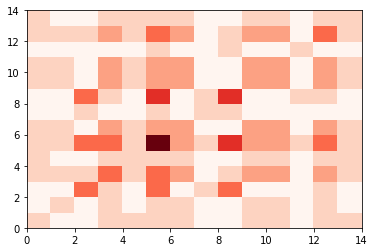

In [7]:
plt.pcolor(X, cmap=plt.cm.Reds) 
plt.show()

### Que ingredientes no nos aprotan informacion??

Usamos la matriz para verlo. La diagonal dice como de habitual es un ingrediente comparando con todas las posibilidades.

- 0 no puedes ser
- si es cerca de zero, es un ingrediente muy poco habitual
- si es cerca de 1 es que aparece en absolutamente todos los platos
- si es cerca de 1 es muy habitual y por tanto no nos aporta mucha informacion.


Veamos en practica. Aggaramos la diagonal y la ordenamos descendiente. Sale algo asi:

In [8]:
usual_ingredients = pd.Series(np.diag(X), index=X.index).sort_values(ascending = False)
usual_ingredients

patata            1.00
pimiento          0.67
ternera           0.50
lomo              0.50
huevo             0.50
pimiento verde    0.33
pimiento rojo     0.33
pechuga pollo     0.33
txistorra         0.17
pollo             0.17
pechugas          0.17
morcilla          0.17
asado variado     0.17
asado completo    0.17
dtype: float64

Por lo tanto la patata aparece en todos los platos. 

Seguido por pimiento que aparecen 67% de los platos* 
(*ojo con discriminador: pimiento vs. pimiento verde vs. pimiento rojo - esto para luego). 

Lomo, ternera y huevo 
aparece en la mitad de todos los platos... Mas abajo aparecen ya los discriminadores.

## 4. Machine Learning

Ahora podemos jugar con el machine learning. Usamos el K-means por ejemplo y miramos que platos se parecen. 
Queremos tener ```n_clusters=3``` grupos.

In [9]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
gropped_dishes = pd.DataFrame({"name": names, "group": kmeans.labels_})
gropped_dishes = gropped_dishes.sort_values("group")
gropped_dishes.set_index("group")

,name
group,
0,plato combinado 5
1,plato combinado 1
1,plato combinado 2
1,plato combinado 3
1,plato combinado 4
2,plato combinado 6


Los platos 1-4 se parecen, 5 es distinto y el 6 es distino.

### Como se parecen?

Para calcular la 'pareciencia' entre los platos de momento solo utilizo los ingredientes que le componen. Hacemos la distancia de *yule* que definimos de tal manera:

Sea $v$ vector binario que nos dice si un plato lleva un ingrediente o no. La intuicion:
- Decimos que los dos platos son iguales si llevan los mismos ingredientes. 
- Decimos que los platos se parecen si los ingredientes que llevan coinciden bastante. 
- Decimos que los platos son muy distintos si comparten muy pocos ingredientes. 

La distancia entre plato $i$ e $j$ definimos formalmente como:

$$ 
distancia_{i,j} = 1 - \|  \frac{2(\text{numero_de_ingredientes_que_no_comparten})}{\text{numero_total_de_ingredientes}} \rVert  = 1 - \lVert yule.distance_{i,j} \rVert 
$$

Lo que en codigo seria algo que usa paquete *spatial* de la libreria *scipy*



In [10]:
Y = dist.squareform(dist.pdist(np.matrix(df), 'yule'))
dish_similarity = pd.DataFrame((1 - Y / 2).round(2), index=names, columns=names)

Lo que nos va generar una matriz como esta:

In [11]:
dish_similarity

,plato combinado 1,plato combinado 2,plato combinado 3,plato combinado 4,plato combinado 5,plato combinado 6
plato combinado 1,1.00,0.90,0.90,0.90,0.29,0.16
plato combinado 2,0.90,1.00,0.96,0.96,0.50,0.30
plato combinado 3,0.90,0.96,1.00,0.96,0.18,0.08
plato combinado 4,0.90,0.96,0.96,1.00,0.50,0.30
plato combinado 5,0.29,0.50,0.18,0.50,1.00,0.89
plato combinado 6,0.16,0.30,0.08,0.30,0.89,1.00


Asi que podemos dibujar el heatmap y ver que efectivamente los platos 1-4 se parecen mucho, y los 5-6 dos se parecen mas entere ellos per un poco menos. 

Lo bueno que esto es coherente con con el algoritmo de *K-means* y nuestra intuicion.

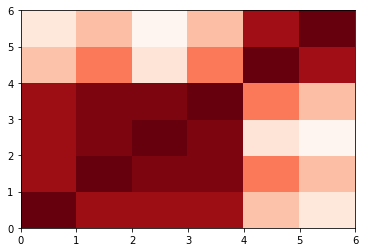

In [12]:
plt.pcolor(dish_similarity, cmap=plt.cm.Reds)
plt.show()

## 5. Sistema de Recomendacion 

Sabiendo los platos parecidos podemos montar un sistema de recomendacion. Si te gusta este plato quizas tambien te 
gustaría este otro. Seria algo asi como: Para cada plato dame 3 platos que se le parecen y se lo recomendamos 
a la persona.

In [13]:
recomender_names = ['Original dish', 'Recommend 1', 'Recommend 2', 'Recommend 3']
recomendations = pd.DataFrame([dish_similarity.ix[i].sort_values(ascending=False)[0:4].index for i in range(6)], columns = recomender_names)
recomendations = recomendations.set_index('Original dish')
recomendations

,Recommend 1,Recommend 2,Recommend 3
Original dish,,,
plato combinado 1,plato combinado 4,plato combinado 3,plato combinado 2
plato combinado 2,plato combinado 4,plato combinado 3,plato combinado 1
plato combinado 3,plato combinado 4,plato combinado 2,plato combinado 1
plato combinado 4,plato combinado 3,plato combinado 2,plato combinado 1
plato combinado 5,plato combinado 6,plato combinado 4,plato combinado 2
plato combinado 6,plato combinado 5,plato combinado 4,plato combinado 2
